In [1]:
import pandas
import glob
import numpy as np
import pandas as pd

In [2]:
unitListingsDf = pd.read_pickle('data/unitListingsDf.Cleaned.pkl')
unitListingsDf.shape

(27829, 26)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

(750, 12000)

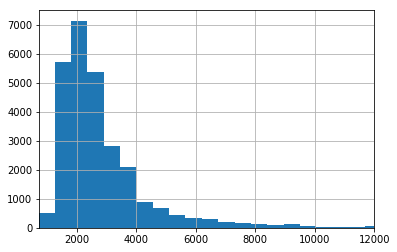

In [4]:
ax = unitListingsDf.price.hist(bins=200)
#ax.set_xscale('log')
ax.set_xlim([750,12000])

/Users/cooldude/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


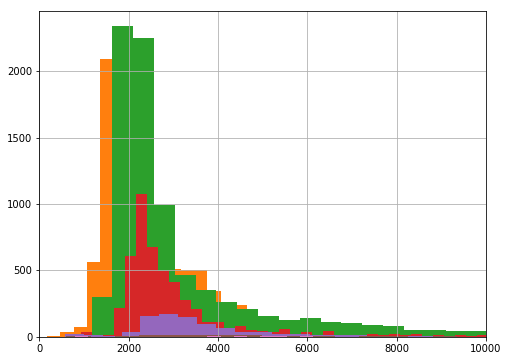

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
unitListingsDf.groupby('bedrooms').price.hist(bins=200, ax= ax)
fig.set_size_inches(8,6)
ax.set_xlim([0,10000])
ax.legend(loc='best')


In [16]:
import plotly.plotly as py
from plotly.graph_objs import *

mapbox_access_token = 'pk.eyJ1Ijoic3JhbmF3ZWVyYSIsImEiOiJjajJubm4yMzkwMXZxMzJxd3ltNGMzOTU1In0.JnEQGilfKySrin6-j3Y55g'

data = Data([
    Scattermapbox(
        lat=['45.5017'],
        lon=['-73.5673'],
        mode='markers',
        marker=Marker(
            size=14
        ),
        text=['Montreal'],
    )
])

layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=45,
            lon=-73
        ),
        pitch=0,
        zoom=5
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Montreal Mapbox')

In [6]:
# import seaborn as sns
# t = mergeNeighborhoodMapping(unitListingsDf.copy())


# ax = sns.boxplot(x='Borough', y='price',data = t[t.bedrooms == 1])
# ax.set_ylim((0,7000))
# sns.despine(trim=True)

In [7]:
import numpy as np

def createLogColumns(df):
    df = df.copy()
    df['log_price'] = np.log(df['price'])
    df['log_bedrooms'] = np.log(df.bedrooms + 1)
    df['log_baths'] = np.log(df.baths)
    df['sqrt_baths'] = np.sqrt(df.baths)
    df['log_commuteDistance'] = np.log(df.commuteDistance)
    df['sqrt_commuteDistance'] = np.sqrt(df.commuteDistance)
    return(df)

In [8]:
def createSqrtColumns(df):
    df = df.copy()
    df['sqrt_baths'] = np.sqrt(df.baths)
    df['log_commuteDistance'] = np.log(df.commuteDistance)
    df['sqrt_commuteDistance'] = np.sqrt(df.commuteDistance)
    return(df)

Hash zips to neighborhood

In [9]:
def mergeNeighborhoodMapping(df):
    url = 'https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm'

    neighborhoodsDf = pd.read_html(url)[0]

    neighborhoodsDf = neighborhoodsDf.loc[1:]

    neighborhoodsDf['shift'] = False
    neighborhoodsDf.loc[neighborhoodsDf.iloc[:,2].isnull(), 'shift'] = True

    neighborhoodsDf.loc[neighborhoodsDf.loc[:,'shift'], 2] = neighborhoodsDf.loc[neighborhoodsDf.loc[:,'shift'],1]
    neighborhoodsDf.loc[neighborhoodsDf.loc[:,'shift'], 1] = neighborhoodsDf.loc[neighborhoodsDf.loc[:,'shift'],0]
    neighborhoodsDf.loc[neighborhoodsDf['shift'] == True, 0 ] = None

    neighborhoodsDf = neighborhoodsDf.iloc[:,0:3]

    neighborhoodsDf.columns = ['Borough', 'Neighborhood', 'Zips']

    neighborhoodsDf.Borough = neighborhoodsDf.Borough.fillna(method='ffill')

    neighborhoodsDf.Zips = neighborhoodsDf.Zips.str.split(',')

    tempZipDF = pd.concat([pd.DataFrame({'zipCode':v}, index=np.repeat(k,len(v))) 
                for k,v in neighborhoodsDf.Zips.to_dict().items()])   

    neighborhoodsDf = (
        neighborhoodsDf.merge(tempZipDF, left_index=True, right_index=True)
        .loc[:,['Borough', 'Neighborhood', 'zipCode']]
    )

    neighborhoodsDf.zipCode = neighborhoodsDf.zipCode.str.strip()
    
    return(df.merge(neighborhoodsDf, how='left', on='zipCode'))

In [10]:
#incomeDf = scrapeAllZips(unitListingsDf.zipCode.unique())
#incomeDf.to_pickle('data/originalIncomeByZipData.pkl')
#populationDf = scrapeAllZipsForPopulation(unitListingsDf.zipCode.unique())
#populationDf.to_pickle('data/originalPopulationByZipData.pkl')
#incomeDf['value'] = incomeDf.value.str.replace('$','').str.replace(',','').str.replace('%','').astype(float)
#populationDf

def scrapeMedianIncome(zipCode):
    t3 = pd.read_html('http://www.point2homes.com/US/Neighborhood/NY/New-York-City/' + zipCode + '-Demographics.html')
    t3 = t3[6]
    t3.columns = ['statistic', 'value']
    t3['zipCode'] = zipCode
    return(t3)

def scrapePopulation(zipCode):
    t3 = pd.read_html('http://www.point2homes.com/US/Neighborhood/NY/New-York-City/' + zipCode + '-Demographics.html')
    t3 = t3[0]
    t3.columns = ['statistic', 'value']
    t3['zipCode'] = zipCode
    return(t3)

def scrapeAllZipsForIncome(zipCodeList):
    incomeDf = None
    for zipCode in zipCodeList:
        try:
            if incomeDf is None:
                incomeDf = scrapeMedianIncome(zipCode)
            else:
                incomeDf = incomeDf.append([scrapeMedianIncome(zipCode)])
        except:
            print('Zip didnt work ' + zipCode)
            pass
    
    return incomeDf


def scrapeAllZipsForPopulation(zipCodeList):
    populationDf = None
    for zipCode in zipCodeList:
        try:
            if populationDf is None:
                populationDf = scrapePopulation(zipCode)
            else:
                populationDf = populationDf.append([scrapePopulation(zipCode)])
        except:
            print('Zip didnt work ' + zipCode)
            pass
    
    return populationDf


def cleanStatisticAndReturnDf(df):
    #df['value'] = df.value.str.replace('$','').str.replace(',','').str.replace('%','').astype(float)
    return(df.pivot(index='zipCode', columns='statistic', values='value'))
    
def mergeIncomePopulationsStats(df):
    incomeDf = pd.read_pickle('data/originalIncomeByZipData.pkl')
    populationDf = pd.read_pickle('data/originalPopulationByZipData.pkl')

    nycStatsDf = cleanStatisticAndReturnDf(incomeDf).merge(cleanStatisticAndReturnDf(populationDf), 
                                              left_index=True, 
                                              right_index=True)

    nycStatsDf.columns =  nycStatsDf.columns.str.replace(' ','').str.replace('/','')
    
    df = df.merge(nycStatsDf, left_on='zipCode', how="left", right_index=True)
    
    return(df)

In [11]:
# def wavg(group, avg_name, weight_name):
#     """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
#     In rare instance, we may not have weights, so just return the mean. Customize this if your business case
#     should return otherwise.
#     """
#     d = group[avg_name]
#     w = group[weight_name]
#     try:
#         return (d * w).sum() / w.sum()
#     except ZeroDivisionError:
#         return d.mean()
    

# medianIncomeByNeighborhood = neighborhoodsDf.merge(nycStatsDf, left_on='zipCode', right_index=True).groupby('Neighborhood').apply(wavg, 'MedianHouseholdIncome', 'TotalPopulation' ).reset_index()
# medianIncomeByNeighborhood.columns = ['Neighborhood', 'MedianIncome']
# medianAgeByNeighborhood = neighborhoodsDf.merge(nycStatsDf, left_on='zipCode', right_index=True).groupby('Neighborhood').apply(wavg, 'MedianAge', 'TotalPopulation' ).reset_index()
# medianAgeByNeighborhood.columns = ['Neighborhood', 'MedianAge']

# medianAgeByNeighborhood.head()
# medianIncomeByNeighborhood.head()

# medianIncomeByNeighborhood.isnull().sum()

In [12]:
#unitListingsDf = unitListingsDf.merge(neighborhoodsDf, how='left', on='zipCode')

In [13]:
propAmenityCounts = (unitListingsDf.origpropertyAmenities
 .apply(lambda x: pd.Series(x)).unstack()
 .value_counts().reset_index())

propAmenityCounts.columns = ['amenity', 'cnt']
topPropAmenities = propAmenityCounts.loc[-propAmenityCounts.amenity.str.contains('MLS',regex=False)].head(30).amenity.tolist()

unitAmenityCounts = (unitListingsDf.origunitAmenities
 .apply(lambda x: pd.Series(x)).unstack()
 .value_counts().reset_index())

unitAmenityCounts.columns = ['amenity', 'cnt']
topUnitAmenities = unitAmenityCounts.loc[-unitAmenityCounts.amenity.str.contains('MLS',regex=False)].head(15).amenity.tolist()


def oneHotAmmenties(unitListingsDf, topPropAmenities, topUnitAmenities):
    topAmenitiesList = list(set(topPropAmenities + topUnitAmenities))
    t = pd.concat([unitListingsDf, pd.DataFrame(columns=topAmenitiesList)])
    t[topAmenitiesList ] = 0

    def propAmenityTransform(x):
        for col in set(x.origpropertyAmenities + x.origunitAmenities):
            if col in topAmenitiesList:
                x[col] = 1
        return(x)

    t = t.apply(lambda x: propAmenityTransform(x), axis=1)
    return(t)

In [14]:
import patsy

def oneHotNeighborhoods(df):
    return(df.join(patsy.dmatrix('Neighborhood', data=df, return_type='dataframe')))

In [15]:
#dataset = oneHotAmmenties(oneHotNeighborhoods(unitListingsDf), topPropAmenities, topUnitAmenities).select_dtypes(exclude=['object'])
dataset = createLogColumns(unitListingsDf)
dataset = createLogColumns(dataset)

dataset = mergeNeighborhoodMapping(dataset)

dataset = mergeIncomePopulationsStats(dataset)



oneHotAmenitiesDf = oneHotAmmenties(dataset, topPropAmenities, topUnitAmenities)
oneHotAmenitiesDf.columns = [col.replace(' ','').replace('/','') for col in oneHotAmenitiesDf.columns]

dataset = pd.concat([dataset, oneHotAmenitiesDf])

dataset = oneHotNeighborhoods(dataset)


colsToKeep = [x for x in dataset.columns if not 'orig'in x]
#colsToKeep = [x for x in colsToKeep if not x in ('Neighborhood', 'Borough', 'zipCode')]
#print(colsToKeep)
#colsToKeep = [x for x in colsToKeep if not ('log_' + x) in colsToKeep]
#print(colsToKeep)
#colsToKeep = [x for x in colsToKeep if not x in ['log_baths', 'log_commuteDistance']]
#print(colsToKeep)
dataset = dataset[colsToKeep].select_dtypes(exclude=['object']).dropna()
#print(colsToKeep)
print(dataset.columns)




Index(['AdditionalStorage', 'AirConditioning', 'Alarm',
       'AverageHouseholdIncome', 'AverageHouseholdNetWorth',
       'AverageHouseholdTotalExpenditure', 'Balcony', 'Balcony,Deck,orPatio',
       'BikeRoom', 'CableReady',
       ...
       'Neighborhood[T.Southeast Queens]', 'Neighborhood[T.Southern Brooklyn]',
       'Neighborhood[T.Southwest Brooklyn]',
       'Neighborhood[T.Southwest Queens]',
       'Neighborhood[T.Stapleton and St. George]',
       'Neighborhood[T.Sunset Park]', 'Neighborhood[T.Upper East Side]',
       'Neighborhood[T.Upper West Side]',
       'Neighborhood[T.West Central Queens]', 'Neighborhood[T.West Queens]'],
      dtype='object', length=110)


In [16]:
[i for i in dataset.columns if 'Neighborhood[' in i]

['Neighborhood[T.Bronx Park and Fordham]',
 'Neighborhood[T.Bushwick and Williamsburg]',
 'Neighborhood[T.Canarsie and Flatlands]',
 'Neighborhood[T.Central Bronx]',
 'Neighborhood[T.Central Brooklyn]',
 'Neighborhood[T.Central Harlem]',
 'Neighborhood[T.Central Queens]',
 'Neighborhood[T.Chelsea and Clinton]',
 'Neighborhood[T.East Harlem]',
 'Neighborhood[T.East New York and New Lots]',
 'Neighborhood[T.Flatbush]',
 'Neighborhood[T.Gramercy Park and Murray Hill]',
 'Neighborhood[T.Greenpoint]',
 'Neighborhood[T.Greenwich Village and Soho]',
 'Neighborhood[T.High Bridge and Morrisania]',
 'Neighborhood[T.Hunts Point and Mott Haven]',
 'Neighborhood[T.Inwood and Washington Heights]',
 'Neighborhood[T.Jamaica]',
 'Neighborhood[T.Kingsbridge and Riverdale]',
 'Neighborhood[T.Lower East Side]',
 'Neighborhood[T.Lower Manhattan]',
 'Neighborhood[T.Mid-Island]',
 'Neighborhood[T.North Queens]',
 'Neighborhood[T.Northeast Bronx]',
 'Neighborhood[T.Northeast Queens]',
 'Neighborhood[T.Northwe

In [17]:
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [18]:
#sns.heatmap(dataset.corr())

In [19]:
subDataset = dataset.loc[:,['log_price','baths', 'bedrooms', 'commuteDistance', 
       'AdditionalStorage', 'AirConditioning', 'Alarm',
       'Balcony', 'Balcony,Deck,orPatio',
       'BikeRoom', 'CableReady', 'CatsAllowed', 'CentralAc', 'Concierge',
       'ControlledAccess', 'Deck', 'Dishwasher', 'DogsAllowed',
       'DoorAttendant', 'DoublePaneWindows', 'Elevator', 'FemalePopulation',
       'FiosAvailable', 'FitnessCenter', 'FloorCovering:Hardwood',
       'FullTimeDoorman', 'Garage', 'Garden', 'Granitecountertop',
       'GuarantorOk', 'Guarantors', 'HardwoodFloors', 'Heatingincludedinrent',
       'Hotwaterincludedinrent', 'Laundry', 'LiveInSuper', 
       
        'MedianHouseholdIncome', 'MedianAge',
                            
        'Neighborhood[T.Bronx Park and Fordham]',
 'Neighborhood[T.Bushwick and Williamsburg]',
 'Neighborhood[T.Canarsie and Flatlands]',
 'Neighborhood[T.Central Bronx]',
 'Neighborhood[T.Central Brooklyn]',
 'Neighborhood[T.Central Harlem]',
 'Neighborhood[T.Central Queens]',
 'Neighborhood[T.Chelsea and Clinton]',
 'Neighborhood[T.East Harlem]',
 'Neighborhood[T.East New York and New Lots]',
 'Neighborhood[T.Flatbush]',
 'Neighborhood[T.Gramercy Park and Murray Hill]',
 'Neighborhood[T.Greenpoint]',
 'Neighborhood[T.Greenwich Village and Soho]',
 'Neighborhood[T.High Bridge and Morrisania]',
 'Neighborhood[T.Hunts Point and Mott Haven]',
 'Neighborhood[T.Inwood and Washington Heights]',
 'Neighborhood[T.Jamaica]',
 'Neighborhood[T.Kingsbridge and Riverdale]',
 'Neighborhood[T.Lower East Side]',
 'Neighborhood[T.Lower Manhattan]',
 'Neighborhood[T.Mid-Island]',
 'Neighborhood[T.North Queens]',
 'Neighborhood[T.Northeast Bronx]',
 'Neighborhood[T.Northeast Queens]',
 'Neighborhood[T.Northwest Brooklyn]',
 'Neighborhood[T.Northwest Queens]',
 'Neighborhood[T.Port Richmond]',
 'Neighborhood[T.Rockaways]',
 'Neighborhood[T.South Shore]',
 'Neighborhood[T.Southeast Bronx]',
 'Neighborhood[T.Southeast Queens]',
 'Neighborhood[T.Southern Brooklyn]',
 'Neighborhood[T.Southwest Brooklyn]',
 'Neighborhood[T.Southwest Queens]',
 'Neighborhood[T.Stapleton and St. George]',
 'Neighborhood[T.Sunset Park]',
 'Neighborhood[T.Upper East Side]',
 'Neighborhood[T.Upper West Side]',
 'Neighborhood[T.West Central Queens]',
 'Neighborhood[T.West Queens]'
                           ]]
X = subDataset[ [col for col in subDataset.columns if not 'price' in col]]
y = dataset['log_price']

In [20]:
X_train_allCols, X_test_allCols, y_train, y_test = train_test_split(X, y, test_size=0.3)



In [23]:
X_train_sm0 = X_train_allCols.copy()
X_train_sm0['intercept'] = 1

X_test_sm0 = X_test_allCols.copy()
X_test_sm0['intercept'] = 1

# Create your model
model = sm.OLS(y_train, X_train_sm0)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1570.
Date:                Tue, 25 Apr 2017   Prob (F-statistic):               0.00
Time:                        23:10:21   Log-Likelihood:                -1861.2
No. Observations:               38462   AIC:                             3880.
Df Residuals:                   38383   BIC:                             4557.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------------
baths                                             0.3028      0.003    101.323      0.000         0.297     0.309
bedrooms                                          0.1450      0.002     94.642      0.000         0.142     0.148
commuteDistance                                  -0.0424      0.002    -24.727      0.000        -0.046    -0.039
AdditionalStorage                                 0.0018      0.011      0.159      0.874        -0.020     0.024
AirConditioning                                  -0.0826      0.009     -9.619      0.000        -0.099    -0.066
Alarm                                            -0.0068      0.013     -0.513      0.608        -0.033     0.019
Balcony                                           0.0016      0.006      0.266      0.790        -0.010     0.013
Balcony,Deck,orPatio                             -0.0182      0.011     -1.599      0.110        -0.040     0.004
BikeRoom                                         -0.0027      0.005     -0.487      0.627        -0.013     0.008
CableReady                                       -0.0380      0.007     -5.161      0.000        -0.052    -0.024
CatsAllowed                                      -0.0022      0.004     -0.514      0.607        -0.011     0.006
CentralAc                                         0.1012      0.006     17.794      0.000         0.090     0.112
Concierge                                         0.0777      0.007     11.950      0.000         0.065     0.090
ControlledAccess                                  0.0170      0.013      1.298      0.194        -0.009     0.043
Deck                                             -0.0019      0.006     -0.331      0.741        -0.013     0.009
Dishwasher                                        0.0586      0.003     18.126      0.000         0.052     0.065
DogsAllowed                                       0.0209      0.004      5.094      0.000         0.013     0.029
DoorAttendant                                     0.0743      0.006     12.464      0.000         0.063     0.086
DoublePaneWindows                                 0.0105      0.012      0.867      0.386        -0.013     0.034
Elevator                                          0.0830      0.005     18.358      0.000         0.074     0.092
FemalePopulation                               6.435e-07   1.94e-07      3.320      0.001      2.64e-07  1.02e-06
FiosAvailable                                     0.0015      0.005      0.333      0.739        -0.007     0.011
FitnessCenter                                     0.1370      0.005     25.082      0.000         0.126     0.148
FloorCovering:Hardwood                           -0.0536      0.006     -8.447      0.000        -0.066    -0.041
FullT

In [ ]:

# Allow x to have multiple columns
def diagnostic_plot(X_train,y_train,X_test,y_test, rgr):
    plt.figure(figsize=(15,10
                       ))
    scaler = StandardScaler()
    xcols = X_train.columns
    X_train = pd.DataFrame(scaler.fit_transform(X_train))
    X_train.columns = xcols

    X_test = pd.DataFrame(scaler.transform(X_test))
    X_test.columns = xcols
    
    #rgr = LinearRegression()
    #if len(x.shape) == 1:
    #    x = x[:,None]
    rgr.fit(X_train,y_train)
    
    # Print out the R^2 for the traing dataset
    print('Training set R2: ' + str(rgr.score(X_train,y_train)))

    # Print out the R^2 for the test dataset
    print('Test set R2: ' + str(rgr.score(X_test,y_test)))
    
    X = X_test.append(X_train)
    y = y_test.append(y_train)
    # Print out the R^2 for the complete dataset
    print('Complete Dataset R2: ' + str(rgr.score(X,y)))
    
    pred_train = rgr.predict(X_train)

    plt.subplot(2, 3, 1)
    #plt.scatter(x[:,0],y)
    sns.regplot(y_train, pred_train, color='red')
#    plt.plot(x[:,0], pred, color='blue',linewidth=1)
    plt.title("Regression fit - Train")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    
    plt.subplot(2, 3, 2)
    res_train = y_train - pred_train
    sns.regplot(y_train, res_train)
    plt.title("Residual plot - Train")
    plt.xlabel("Actual price")
    plt.ylabel("residuals")
    
    plt.subplot(2, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res_train, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot - Train")
    
    
    pred_test = rgr.predict(X_test)

    plt.subplot(2, 3, 4)
    #plt.scatter(x[:,0],y)
    sns.regplot(y_test, pred_test, color='red')
#    plt.plot(x[:,0], pred, color='blue',linewidth=1)
    plt.title("Regression fit - Test")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    
    plt.subplot(2, 3, 5)
    res_test = y_test - pred_test
    sns.regplot(y_test, res_test)
    plt.title("Residual plot - Test")
    plt.xlabel("Actual price")
    plt.ylabel("residuals")
    
    plt.subplot(2, 3, 6)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res_test, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot - Test")
    #print(rgr.score(X_test,y_test))
    
    #pred = rgr.predict(X)
    
#     plt.subplot(3, 3, 7)
#     #plt.scatter(x[:,0],y)
#     sns.regplot(y, pred, color='red')
# #    plt.plot(x[:,0], pred, color='blue',linewidth=1)
#     plt.title("Regression fit - Complete Set")
#     plt.xlabel("Actual Price")
#     plt.ylabel("Predicted Price")
    
#     plt.subplot(3, 3, 8)
#     res = y- pred
#     sns.regplot(y, res)
#     plt.title("Residual plot - Complete Set")
#     plt.xlabel("Actual price")
#     plt.ylabel("residuals")
    
#     plt.subplot(3, 3, 9)
#     #Generates a probability plot of sample data against the quantiles of a 
#     # specified theoretical distribution 
#     stats.probplot(res, dist="norm", plot=plt)
#     plt.title("Normal Q-Q plot - Complete Set")

    return(rgr)

In [ ]:

def runModel(model, X_train, X_test, y_train, y_test):
    model = LinearRegression()

    # Fit the model
    model.fit(X_train, y_train)


    
    diagnostic_plot(X_train,y_train,X_test,y_test, model)

#### baths, bedrooms, commuteDistance####

In [ ]:
cols = ['baths', 'bedrooms', 'commuteDistance'#,
#        'AdditionalStorage', 'AirConditioning', 'Alarm',
#        'Balcony', 'Balcony,Deck,orPatio',
#        'BikeRoom', 'CableReady', 'CatsAllowed', 'CentralAc', 'Concierge',
#        'ControlledAccess', 'Deck', 'Dishwasher', 'DogsAllowed',
#        'DoorAttendant', 'DoublePaneWindows', 'Elevator', 'FemalePopulation',
#        'FiosAvailable', 'FitnessCenter', 'FloorCovering:Hardwood',
#        'FullTimeDoorman', 'Garage', 'Garden', 'Granitecountertop',
#        'GuarantorOk', 'Guarantors', 'HardwoodFloors', 'Heatingincludedinrent',
#        'Hotwaterincludedinrent', 'Laundry', 'LiveInSuper', 
       
        #'MedianHouseholdIncome', 
        #'MedianAge'
]
                           

X_train1 = X_train_allCols.loc[:, cols]
X_test1 = X_test_allCols.loc[:, cols]

X_train_sm1 = X_train1.copy()
X_train_sm1['intercept'] = 1

X_test_sm1 = X_test1.copy()
X_test_sm1['intercept'] = 1

In [ ]:
rgrLR = diagnostic_plot(X_train1,y_train,X_test1,y_test, LinearRegression(normalize=True))

In [ ]:
# rgrRFE = diagnostic_plot(X_train1, y_train, X_test1,y_test, RFECV(LinearRegression(),cv=5))

In [ ]:
rgrRFE = diagnostic_plot(X_train1, y_train, X_test1,y_test, RidgeCV(cv=5, normalize=True, alphas=[0.1, 1.0, 10.0]))

In [ ]:
rgrRFE = diagnostic_plot(X_train1, y_train, X_test1,y_test, ElasticNetCV(cv=5, normalize=True))

In [ ]:
rgrRFE = diagnostic_plot(X_train1, y_train, X_test1,y_test, RFECV(LinearRegression(normalize=True),cv=5))

#### Add Median Age, Median Household Income####

In [ ]:
cols = ['baths', 'bedrooms', 'commuteDistance',
#        'AdditionalStorage', 'AirConditioning', 'Alarm',
#        'Balcony', 'Balcony,Deck,orPatio',
#        'BikeRoom', 'CableReady', 'CatsAllowed', 'CentralAc', 'Concierge',
#        'ControlledAccess', 'Deck', 'Dishwasher', 'DogsAllowed',
#        'DoorAttendant', 'DoublePaneWindows', 'Elevator', 'FemalePopulation',
#        'FiosAvailable', 'FitnessCenter', 'FloorCovering:Hardwood',
#        'FullTimeDoorman', 'Garage', 'Garden', 'Granitecountertop',
#        'GuarantorOk', 'Guarantors', 'HardwoodFloors', 'Heatingincludedinrent',
#        'Hotwaterincludedinrent', 'Laundry', 'LiveInSuper', 
       
        'MedianHouseholdIncome'#, 
        #'MedianAge'
]
                           

X_train = X_train_allCols.loc[:, cols]
X_test = X_test_allCols.loc[:, cols]

X_train_sm = X_train.copy()
X_train_sm['intercept'] = 1

X_test_sm = X_test.copy()
X_test_sm['intercept'] = 1

In [ ]:
rgrRFE = diagnostic_plot(X_train, y_train, X_test,y_test, ElasticNetCV(cv=5, normalize=True))


In [ ]:
cols = ['baths', 'bedrooms', 'commuteDistance',
#        'AdditionalStorage', 'AirConditioning', 'Alarm',
#        'Balcony', 'Balcony,Deck,orPatio',
#        'BikeRoom', 'CableReady', 'CatsAllowed', 'CentralAc', 'Concierge',
#        'ControlledAccess', 'Deck', 'Dishwasher', 'DogsAllowed',
#        'DoorAttendant', 'DoublePaneWindows', 'Elevator', 'FemalePopulation',
#        'FiosAvailable', 'FitnessCenter', 'FloorCovering:Hardwood',
#        'FullTimeDoorman', 'Garage', 'Garden', 'Granitecountertop',
#        'GuarantorOk', 'Guarantors', 'HardwoodFloors', 'Heatingincludedinrent',
#        'Hotwaterincludedinrent', 'Laundry', 'LiveInSuper', 
       
        'MedianHouseholdIncome', 
        'MedianAge'
]
                           

X_train = X_train_allCols.loc[:, cols]
X_test = X_test_allCols.loc[:, cols]

X_train_sm = X_train.copy()
X_train_sm['intercept'] = 1

X_test_sm = X_test.copy()
X_test_sm['intercept'] = 1

rgrRFE = diagnostic_plot(X_train, y_train, X_test,y_test, RidgeCV(normalize=True,cv=5))

In [ ]:
cols = ['baths', 'bedrooms', 'commuteDistance',
       'AdditionalStorage', 'AirConditioning', 'Alarm',
       'Balcony', 'Balcony,Deck,orPatio',
       'BikeRoom', 'CableReady', 'CatsAllowed', 'CentralAc', 'Concierge',
       'ControlledAccess', 'Deck', 'Dishwasher', 'DogsAllowed',
       'DoorAttendant', 'DoublePaneWindows', 'Elevator',
       'FiosAvailable', 'FitnessCenter', 'FloorCovering:Hardwood',
       'FullTimeDoorman', 'Garage', 'Garden', 'Granitecountertop',
       'GuarantorOk', 'Guarantors', 'HardwoodFloors', 'Heatingincludedinrent',
       'Hotwaterincludedinrent', 'Laundry', 'LiveInSuper', 
       
        'MedianHouseholdIncome', 
        'MedianAge'
]

X_train = X_train_allCols.loc[:, cols]
X_test = X_test_allCols.loc[:, cols]

X_train_sm = X_train.copy()
X_train_sm['intercept'] = 1

X_test_sm = X_test.copy()
X_test_sm['intercept'] = 1

rgrRFE = diagnostic_plot(X_train, y_train, X_test,y_test, RidgeCV(normalize=True,cv=5))

In [ ]:
from sklearn.preprocessing import normalize

tempDf = pd.DataFrame(normalize(X_train_sm))
tempDf.columns = X_train_sm.columns

model = sm.OLS(y_train, X_train_sm)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
print(fit.summary())

pd.DataFrame(fit.params).sort_values(0,ascending=False)

In [ ]:
cols = ['baths', 'bedrooms', 'commuteDistance',
       'AdditionalStorage', 'AirConditioning', 'Alarm',
       'Balcony', 'Balcony,Deck,orPatio',
       'BikeRoom', 'CableReady', 'CatsAllowed', 'CentralAc', 'Concierge',
       'ControlledAccess', 'Deck', 'Dishwasher', 'DogsAllowed',
       'DoorAttendant', 'DoublePaneWindows', 'Elevator',
       'FiosAvailable', 'FitnessCenter', 'FloorCovering:Hardwood',
       'FullTimeDoorman', 'Garage', 'Garden', 'Granitecountertop',
       'GuarantorOk', 'Guarantors', 'HardwoodFloors', 'Heatingincludedinrent',
       'Hotwaterincludedinrent', 'Laundry', 'LiveInSuper', 
       
        'MedianHouseholdIncome', 
        'MedianAge',
        
'Neighborhood[T.Bronx Park and Fordham]',
 'Neighborhood[T.Bushwick and Williamsburg]',
 'Neighborhood[T.Canarsie and Flatlands]',
 'Neighborhood[T.Central Bronx]',
 'Neighborhood[T.Central Brooklyn]',
 'Neighborhood[T.Central Harlem]',
 'Neighborhood[T.Central Queens]',
 'Neighborhood[T.Chelsea and Clinton]',
 'Neighborhood[T.East Harlem]',
 'Neighborhood[T.East New York and New Lots]',
 'Neighborhood[T.Flatbush]',
 'Neighborhood[T.Gramercy Park and Murray Hill]',
 'Neighborhood[T.Greenpoint]',
 'Neighborhood[T.Greenwich Village and Soho]',
 'Neighborhood[T.High Bridge and Morrisania]',
 'Neighborhood[T.Hunts Point and Mott Haven]',
 'Neighborhood[T.Inwood and Washington Heights]',
 'Neighborhood[T.Jamaica]',
 'Neighborhood[T.Kingsbridge and Riverdale]',
 'Neighborhood[T.Lower East Side]',
 'Neighborhood[T.Lower Manhattan]',
 'Neighborhood[T.Mid-Island]',
 'Neighborhood[T.North Queens]',
 'Neighborhood[T.Northeast Bronx]',
 'Neighborhood[T.Northeast Queens]',
 'Neighborhood[T.Northwest Brooklyn]',
 'Neighborhood[T.Northwest Queens]',
 'Neighborhood[T.Port Richmond]',
 'Neighborhood[T.Rockaways]',
 'Neighborhood[T.South Shore]',
 'Neighborhood[T.Southeast Bronx]',
 'Neighborhood[T.Southeast Queens]',
 'Neighborhood[T.Southern Brooklyn]',
 'Neighborhood[T.Southwest Brooklyn]',
 'Neighborhood[T.Southwest Queens]',
 'Neighborhood[T.Stapleton and St. George]',
 'Neighborhood[T.Sunset Park]',
 'Neighborhood[T.Upper East Side]',
 'Neighborhood[T.Upper West Side]',
 'Neighborhood[T.West Central Queens]',
 'Neighborhood[T.West Queens]']

X_train4 = X_train_allCols.loc[:, cols]
X_test4 = X_test_allCols.loc[:, cols]

X_train_sm4 = X_train4.copy()
X_train_sm4['intercept'] = 1

X_test_sm4 = X_test4.copy()
X_test_sm4['intercept'] = 1

rgrRFE = diagnostic_plot(X_train4, y_train, X_test4,y_test, RFECV(LinearRegression(),cv=5))

plt.savefig('ModelFit.png', dpi=1024)

In [ ]:
cols = ['baths', 'bedrooms', 'commuteDistance',
       'AdditionalStorage', 'AirConditioning', 'Alarm',
       'Balcony', 'Balcony,Deck,orPatio',
       'BikeRoom', 'CableReady', 'CatsAllowed', 'CentralAc', 'Concierge',
       'ControlledAccess', 'Deck', 'Dishwasher', 'DogsAllowed',
       'DoorAttendant', 'DoublePaneWindows', 'Elevator',
       'FiosAvailable', 'FitnessCenter', 'FloorCovering:Hardwood',
       'FullTimeDoorman', 'Garage', 'Garden', 'Granitecountertop',
       'GuarantorOk', 'Guarantors', 'HardwoodFloors', 'Heatingincludedinrent',
       'Hotwaterincludedinrent', 'Laundry', 'LiveInSuper', 
       
        'MedianHouseholdIncome', 
        'MedianAge',
        
'Neighborhood[T.Bronx Park and Fordham]',
 'Neighborhood[T.Bushwick and Williamsburg]',
 'Neighborhood[T.Canarsie and Flatlands]',
 'Neighborhood[T.Central Bronx]',
 'Neighborhood[T.Central Brooklyn]',
 'Neighborhood[T.Central Harlem]',
 'Neighborhood[T.Central Queens]',
 'Neighborhood[T.Chelsea and Clinton]',
 'Neighborhood[T.East Harlem]',
 'Neighborhood[T.East New York and New Lots]',
 'Neighborhood[T.Flatbush]',
 'Neighborhood[T.Gramercy Park and Murray Hill]',
 'Neighborhood[T.Greenpoint]',
 'Neighborhood[T.Greenwich Village and Soho]',
 'Neighborhood[T.High Bridge and Morrisania]',
 'Neighborhood[T.Hunts Point and Mott Haven]',
 'Neighborhood[T.Inwood and Washington Heights]',
 'Neighborhood[T.Jamaica]',
 'Neighborhood[T.Kingsbridge and Riverdale]',
 'Neighborhood[T.Lower East Side]',
 'Neighborhood[T.Lower Manhattan]',
 'Neighborhood[T.Mid-Island]',
 'Neighborhood[T.North Queens]',
 'Neighborhood[T.Northeast Bronx]',
 'Neighborhood[T.Northeast Queens]',
 'Neighborhood[T.Northwest Brooklyn]',
 'Neighborhood[T.Northwest Queens]',
 'Neighborhood[T.Port Richmond]',
 'Neighborhood[T.Rockaways]',
 'Neighborhood[T.South Shore]',
 'Neighborhood[T.Southeast Bronx]',
 'Neighborhood[T.Southeast Queens]',
 'Neighborhood[T.Southern Brooklyn]',
 'Neighborhood[T.Southwest Brooklyn]',
 'Neighborhood[T.Southwest Queens]',
 'Neighborhood[T.Stapleton and St. George]',
 'Neighborhood[T.Sunset Park]',
 'Neighborhood[T.Upper East Side]',
 'Neighborhood[T.Upper West Side]',
 'Neighborhood[T.West Central Queens]',
 'Neighborhood[T.West Queens]']

X = subDataset.loc[ :, [col for col in subDataset.columns if not 'price' in col]]
y = dataset.loc[:,'log_price']

X_train_allCols, X_test_allCols, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train4 = X_train_allCols.loc[:, cols]
X_test4 = X_test_allCols.loc[:, cols]

X_train_sm4 = X_train4.copy()
X_train_sm4['intercept'] = 1

X_test_sm4 = X_test4.copy()
X_test_sm4['intercept'] = 1

rgrRFE = diagnostic_plot(X_train4, y_train, X_test4,y_test, RFECV(LinearRegression(),cv=5))



In [ ]:
t = pd.DataFrame([X_train4.iloc[:,rgrRFE.get_support(indices=True)].columns,rgrRFE.estimator_.coef_]).T.sort_values(1)
t.loc[t[0].str.contains('Neigh')]

In [ ]:
unitListingsDf.groupby('Borough').price

#### Model Comparison ####

In [ ]:

# Allow x to have multiple columns
def diagnostic_plot_comparison(X_train,y_train,X_test,y_test, rgr):
    plt.figure(figsize=(15,15
                       ))
    
    #rgr = LinearRegression()
    #if len(x.shape) == 1:
    #    x = x[:,None]
    rgr.fit(X_train,y_train)
    
    # Print out the R^2 for the traing dataset
    print('Training set R2: ' + str(rgr.score(X_train,y_train)))

    # Print out the R^2 for the test dataset
    print('Test set R2: ' + str(rgr.score(X_test,y_test)))
    
    X = X_test.append(X_train)
    y = y_test.append(y_train)
    # Print out the R^2 for the complete dataset
    print('Complete Dataset R2: ' + str(rgr.score(X,y)))
    
    #pred_train = rgr.predict(X_train)
    
    pred = rgr.predict(X)
    
    fig1 = plt.subplot(2, 1, 1)
    frame = fig1.add_axes((.1,.3,.8,.6))
    #plt.scatter(x[:,0],y)
    sns.regplot(y, pred, color='red')
#    plt.plot(x[:,0], pred, color='blue',linewidth=1)
    plt.title("Regression fit - Complete Set")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    
#     plt.subplot(2, 3, 2)
    res = y- pred
    frame2=fig1.add_axes((.1,.1,.8,.2)) 
    sns.regplot(y, res)
    plt.title("Residual plot - Complete Set")
    plt.xlabel("Actual price")
    plt.ylabel("residuals")
    
    plt.subplot(2, 1, 2)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot - Complete Set")
    
#     rgr.fit(X_train4,y_train)
    
#     pred_train = rgr.predict(X_train4)  
    
#     X = X_test.append(X_train4)
#     y = y_test.append(y_train)
    
#     # Print out the R^2 for the traing dataset
#     print('Training set R2: ' + str(rgr.score(X_train4,y_train)))

#     # Print out the R^2 for the test dataset
#     print('Test set R2: ' + str(rgr.score(X_test4,y_test)))
    
#     X = X_test.append(X_train4)
#     y = y_test.append(y_train)
#     # Print out the R^2 for the complete dataset
#     print('Complete Dataset R2: ' + str(rgr.score(X,y)))
    
#     pred = rgr.predict(X)
    
#     plt.subplot(2, 3, 1)
#     #plt.scatter(x[:,0],y)
#     sns.regplot(y, pred, color='red')
# #    plt.plot(x[:,0], pred, color='blue',linewidth=1)
#     plt.title("Regression fit - Complete Set")
#     plt.xlabel("Actual Price")
#     plt.ylabel("Predicted Price")
    
#     plt.subplot(2, 3, 2)
#     res = y- pred
#     sns.regplot(y, res)
#     plt.title("Residual plot - Complete Set")
#     plt.xlabel("Actual price")
#     plt.ylabel("residuals")
    
#     plt.subplot(2, 3, 3)
#     #Generates a probability plot of sample data against the quantiles of a 
#     # specified theoretical distribution 
#     stats.probplot(res, dist="norm", plot=plt)
#     plt.title("Normal Q-Q plot - Complete Set")

    return(rgr)

In [ ]:
rgr = RFECV(LinearRegression(), cv=5)
rgr.fit(X_train,y_train)

In [ ]:
rgrRFE = diagnostic_plot_comparison(X_train1, y_train, X_test1,y_test,X_train4,X_test4, RFECV(LinearRegression(),cv=5))

In [ ]:
len(unitListingsDf.zipCode.unique())

Create Amenities one hot columns

In [ ]:
pd.read_pickle('allSummaryLinksDF.pkl').shape

In [ ]:
def oneHotAmmenties(unitListingsDf, topPropAmenities, topUnitAmenities):
    topAmenitiesList = list(set(topPropAmenities + topUnitAmenities))
    t = pd.concat([unitListingsDf, pd.DataFrame(columns=topAmenitiesList)])
    t[topAmenitiesList ] = 0

    def propAmenityTransform(x):
        for col in set(x.origpropertyAmenities + x.origunitAmenities):
            if col in topAmenitiesList:
                x[col] = 1
        return(x)

    t = t.apply(lambda x: propAmenityTransform(x), axis=1)
    return(t)

In [ ]:
unitListingsDf.shape

In [ ]:
#unitListingsDf = unitListingsDf.dropna()
numericColumns = unitListingsDf.select_dtypes(exclude=['object']).columns
print(unitListingsDf.shape)
unitListingsDf = unitListingsDf.dropna(subset=numericColumns)
unitListingsDf.shape


In [ ]:
import seaborn as sns

numericColumnsLogsOnly = [col for col in numericColumns if not (('log_' + col) in numericColumns)]

sns.pairplot(unitListingsDf[numericColumnsLogsOnly])

In [ ]:
sns.heatmap(unitListingsDf[numericColumnsLogsOnly].corr())

In [ ]:
import patsy

def oneHotNeighborhoods(unitListingsDf):
    return(unitListingsDf.join(patsy.dmatrix('Neighborhood', data=unitListingsDf, return_type='dataframe')))



In [ ]:
oneHotAmmenties(oneHotNeighborhoods(unitListingsDf), topPropAmenities, topUnitAmenities).isnull()

In [ ]:
unitListingsDf.columns

In [ ]:
unitListingsDf = unitListingsDf.merge(medianAgeByNeighborhood, on = 'Neighborhood').merge(medianIncomeByNeighborhood, on='Neighborhood')


In [ ]:
sns.heatmap(unitListingsDf.corr())

In [ ]:
print(unitListingsDf.columns)

dataset = oneHotAmmenties(oneHotNeighborhoods(unitListingsDf), topPropAmenities, topUnitAmenities).select_dtypes(exclude=['object'])


colsToKeep = [x for x in dataset.columns if not 'orig'in x]
colsToKeep = [x for x in colsToKeep if not x in ('Neighborhood', 'Borough', 'zipCode')]
print(colsToKeep)
colsToKeep = [x for x in colsToKeep if not ('log_' + x) in colsToKeep]
print(colsToKeep)
colsToKeep = [x for x in colsToKeep if not x in ['log_baths', 'log_commuteDistance']]
print(colsToKeep)
dataset = dataset[colsToKeep].dropna()
print(colsToKeep)

X = dataset[ [col for col in colsToKeep if not 'price' in col]]
y = dataset['log_price']

In [ ]:
dataset.shape

In [ ]:

# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
import statsmodels.api as sm
import statsmodels.formula.api as smf




Test/Train split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
X_train.shape

Simple linear regression on training data

In [ ]:

# Create your model
model = sm.OLS(y_train, X_train)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

In [ ]:
X_train.isnull().sum().sort_values(ascending=False)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
#mean_squared_error?

In [ ]:
sns.regplot(y_train, fit.resid)



In [ ]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr.score(X_train,y_train)

In [ ]:
lr.score(X_test,y_test)

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.scatter(lr.predict(X_test),y_test)

min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_val = min(ax.get_xlim()[1], ax.get_ylim()[1])

ax.set_xlim(min_val,max_val)
ax.set_ylim(min_val,max_val)

ax.plot([min_val, max_val], [min_val,max_val])
ax.set_xlabel('predicted log_price')
ax.set_ylabel('actual log_price')



In [ ]:
degree = 2
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
est.fit(X_train, y_train)

In [ ]:
est.score(X_train,y_train)

In [ ]:
est.score(X_test,y_test)

In [ ]:
plt.scatter(est.predict(X_train),y_train)

In [ ]:
plt.scatter(est.predict(X_test),y_test)

In [ ]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(LinearRegression(), step=1, cv=5)#, scoring='neg_mean_squared_error')
rfecv = rfecv.fit(X_train, y_train)
#rfecv.predict(y_test) or rfecv.estimator_.predict(y_test)

In [ ]:
rfecv.score(X_train, y_train)

In [ ]:
rfecv.score(X_test, y_test)

In [ ]:
X_train.shape

In [ ]:
rfecv.n_features_

In [ ]:
coefs = pd.DataFrame({'var':X.iloc[:,rfecv.get_support(indices=True)].columns, 'coef':rfecv.estimator_.coef_})
#coefs.plot.barh(x='var')
coefs.sort_values('coef', ascending=True)
#rfecv.get_support(indices=True)

In [ ]:
from sklearn.linear_model import ElasticNetCV

estElastics = ElasticNetCV(cv=5)
estElastics.fit(X_train, y_train)
estElastics.score(X_train,y_train)

In [ ]:
estElastics.coef_

In [ ]:
from sklearn.feature_selection import RFECV


lr4 = LinearRegression()
rfe = RFECV(lr4, cv=5)
rfe.fit(X_train, y_train)
rfe.score(X_train,y_train)

In [ ]:
rfe.score(X_test,y_test)

In [ ]:
len(rfe.ranking_)

In [ ]:
len(lr.coef_)

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.scatter(rfe.predict(X_test),y_test)

min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_val = min(ax.get_xlim()[1], ax.get_ylim()[1])

ax.set_xlim(min_val,max_val)
ax.set_ylim(min_val,max_val)

ax.plot([min_val, max_val], [min_val,max_val])
ax.set_xlabel('predicted log_price')
ax.set_ylabel('actual log_price')
plt.title('RFE & LinearRegression - Predicted vs. Actual Values')
fig.savefig('RFELinearRegression.png')


In [ ]:

# fig = plt.figure(figsize=(6,6))
# ax = plt.axes()

# (y_test - (rfe.predict(X_test))).plot(style='o')

# min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
# max_val = min(ax.get_xlim()[1], ax.get_ylim()[1])

# ax.set_xlim(min_val,max_val)
# ax.set_ylim(min_val,max_val)

# ax.plot([min_val, max_val], [min_val,max_val])
# ax.set_xlabel('predicted log_price')
# ax.set_ylabel('actual log_price')
# plt.title('RFE & LinearRegression - Predicted vs. Actual Values')
# fig.savefig('RFELinearRegression.png')

In [ ]:
resids  = (y_test - (rfe.predict(X_test)))
#plt.scatter(y_test, resids)
ax = sns.regplot(x=y_test, y=resids)
plt.title('Residuals')
plt.ylabel('Residual')
plt.savefig('RFELinearRegression.Residuals.png')

In [ ]:
#plt.scatter(unitListingsDf.origlatitude, unitListingsDf.origlongitude,
#            color=unitListingsDf.price)

sns.lmplot('origlatitude', 'origlongitude',
           data=unitListingsDf,
           fit_reg=False,
           hue="price",  
           scatter_kws={"marker": "D",
                        "s": 10},
           legend = False )


In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

est = ElasticNetCV()
est.fit(X_train, y_train)
est.score(X_train, y_train)

In [ ]:
est.score(X_test,y_test)